## Data Processing section

In [1]:
# import all necessary libraries
import os
import pandas as pd

import numpy as np

In [2]:
# announce all necessary dirs
def get_dirs(is_kaggle=True):
    if is_kaggle:
        KAGGLE_INPUT = '/kaggle/input'
        MOVIELENS_DIR = os.path.join(KAGGLE_INPUT, 'movielens-20m-dataset')
    else:
        WORK_DIR = '~/Movielens'
        MOVIELENS_DIR = os.path.join(WORK_DIR, 'movielens-20m-dataset')
    RATINGS_DIR = os.path.join(MOVIELENS_DIR, 'rating.csv')
    MOVIES_DIR = os.path.join(MOVIELENS_DIR, 'movie.csv')
    TAGS_DIR = os.path.join(MOVIELENS_DIR, 'tag.csv')
    LINKS_DIR = os.path.join(MOVIELENS_DIR, 'link.csv')
    GENOME_TAGS_DIR = os.path.join(MOVIELENS_DIR, 'genome_tags.csv')
    GENOME_SCORES_DIR = os.path.join(MOVIELENS_DIR, 'genome_scores.csv')

    return {
        'rating_path': RATINGS_DIR,
        'movie_path': MOVIES_DIR,
        'tag_path': TAGS_DIR,
        'link_path': LINKS_DIR,
        'genome_tags_path': GENOME_TAGS_DIR,
        'genome_scores_path': GENOME_SCORES_DIR
    } 

is_kaggle = True
main_path = get_dirs(is_kaggle=is_kaggle)

In [3]:
# read all csv files
movies_cols = ['movieId', 'title', 'genres']
movies = pd.read_csv(main_path['movie_path'], usecols=movies_cols, engine='c')

ratings_cols = ['userId', 'movieId', 'rating']
ratings = pd.read_csv(main_path['rating_path'], usecols=ratings_cols, engine='c')

tags_cols = ['userId', 'movieId', 'tag']
tags = pd.read_csv(main_path['tag_path'], usecols=tags_cols, engine='c')

In [4]:
# cut down our data (because I don't have enough RAM memory to work with it all)
max_user_amount = 35000
max_movie_amount = 15000

ratings = ratings[(ratings['userId'] <= max_user_amount) & (ratings['movieId'] <= max_movie_amount)]

In [5]:
# save ids for dl model in future
max_user_id = ratings['userId'].max()
max_movie_id = ratings['movieId'].max()

print('max_movie_id is:', max_movie_id)
print('max_user_id is:', max_user_id)

max_movie_id is: 9019
max_user_id is: 35000


In [16]:
# make train and test split
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

ratings = shuffle(ratings)
train_ratings, test_ratings = train_test_split(ratings, test_size=0.15)

# create item-based matrix
item_based_matrix_train = np.zeros((max_user_id, max_movie_id))
item_based_matrix_test = np.zeros((max_user_id, max_movie_id))

for line in train_ratings.itertuples():
    item_based_matrix_train[line[1] - 1, line[2] - 1] = line[3]

for line in test_ratings.itertuples():
    item_based_matrix_test[line[1] - 1, line[2] - 1] = line[3]

## Data Exploration

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

First of all let's see how many various words we can see in the titles and how often we can meet them

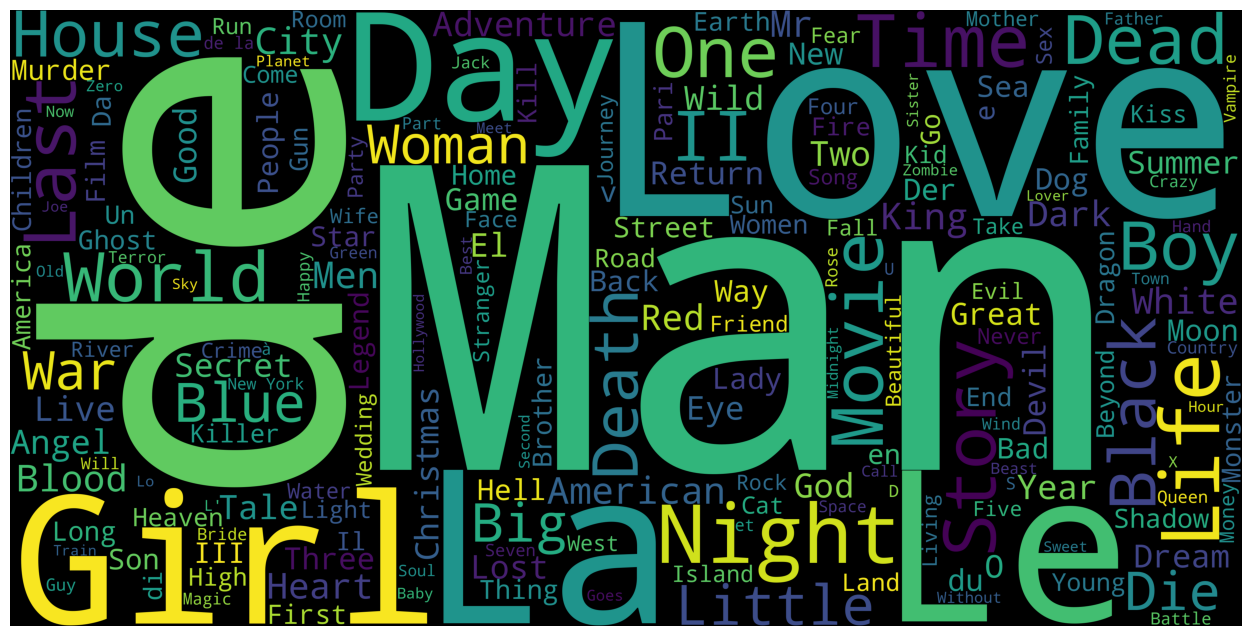

In [31]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS

# Create a wordcloud of the movie titles
movies['title'] = movies['title'].fillna("").astype('str')
title_corpus = ' '.join(movies['title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

Further let's investigate ratings on our movies

In [32]:
# Get summary statistics of rating
ratings['rating'].describe()

count    806313.000000
mean          3.558185
std           1.058723
min           0.500000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

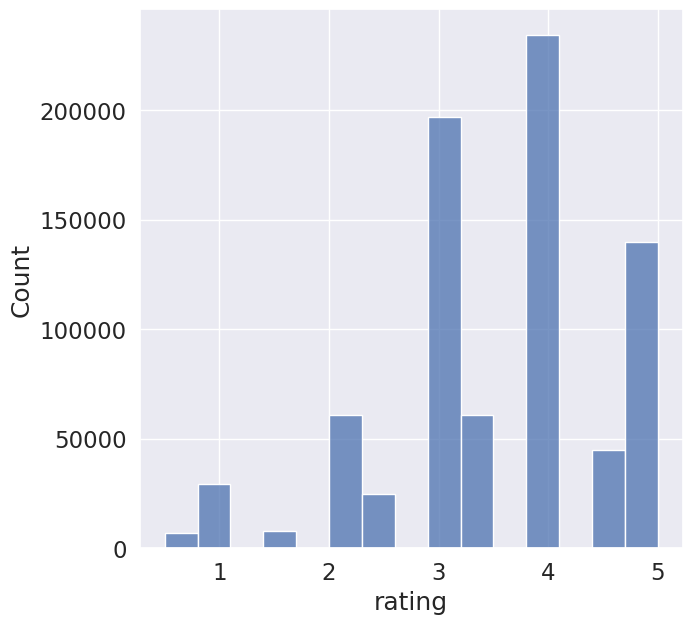

In [42]:
import seaborn as sns
sns.set_style('whitegrid')
sns.set(font_scale=1.5)

# Display distribution of rating
ratings_without_nan = ratings
ratings_without_nan['rating'].fillna(ratings['rating'].median())

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax = sns.histplot(ratings_without_nan, x='rating', binwidth=0.3)

plt.show()

We can see, that most of the users are not against to give high rates to movies

Let's also to make wordcloud also for genres

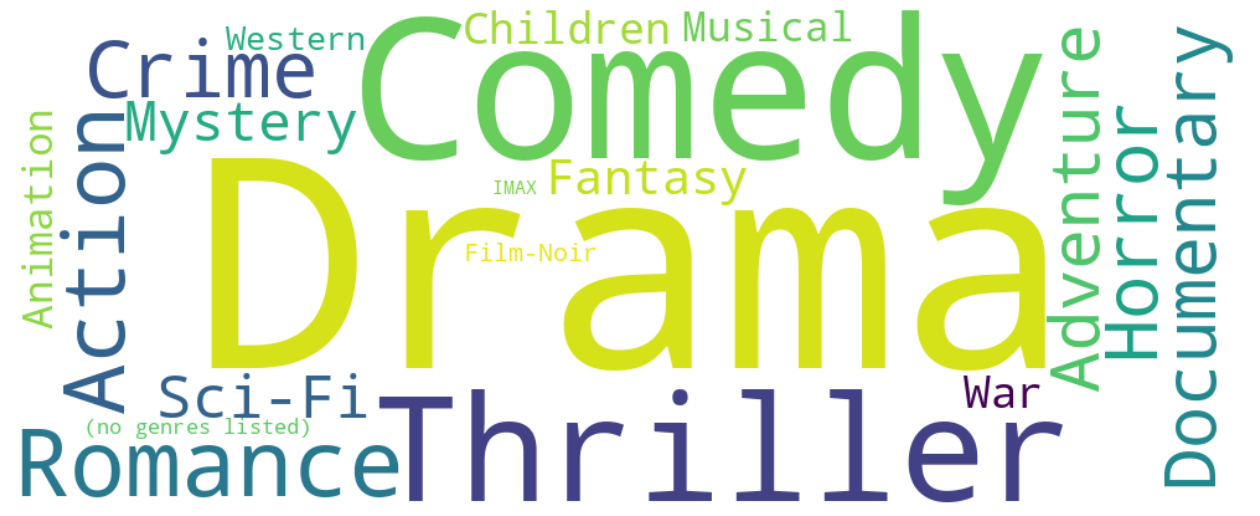

In [51]:
# Count the frequency of each genre
from collections import Counter

genre_labels = dict()
for line in movies['genres'].str.split('|').values:
    for key, value in Counter(line).items():
        if genre_labels.get(key, -1) == -1:
            genre_labels[key] = value
        else:
            genre_labels[key] += value

# Create the wordcloud
genre_wordcloud = WordCloud(width=1000,height=400, background_color='white')
genre_wordcloud.generate_from_frequencies(genre_labels)

# Plot the wordcloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


We can see that the most popular genres are $ Drama $, $ Comedy $, $ Thriller $. We will try to use all this infromation in future

In [91]:
def evaluate(predictions, item_based_matrix):
    """
    calculate RMSE between known values and predicted
    """
    from sklearn.metrics import mean_squared_error

    mask = item_based_matrix > 0
    ground_truth = item_based_matrix[mask].flatten()
    actual = predictions[mask].flatten()

    return mean_squared_error(actual, ground_truth, squared=False)

## Content-Based and Collaborative Filtering

In [105]:
def pirson_corr(item_based_matrix, Id1, Id2, sim_type):
    """
    Pirson correlation
    sim_type: user or item
    """
    # get known ratings
    if sim_type == 'user':
        Id1_ratings = item_based_matrix[Id1]
        Id2_ratings = item_based_matrix[Id2]
    elif sim_type == 'item':
        Id1_ratings = item_based_matrix[:, Id1]
        Id2_ratings = item_based_matrix[:, Id2]
    else:
        sim_type in ['user', 'item']

    # either first or second user is empty
    if (not (np.sum(Id1_ratings) > 0)) or (not (np.sum(Id2_ratings) > 0)):
        return 0

    # calculate mean across each user
    userId1_mean = np.mean(Id1_ratings[Id1_ratings > 0])
    userId2_mean = np.mean(Id2_ratings[Id2_ratings > 0])

    # calculate statistics
    userId1_std = np.sqrt(np.sum((Id1_ratings[Id1_ratings > 0] - userId1_mean) ** 2))
    userId2_std = np.sqrt(np.sum((Id2_ratings[Id2_ratings > 0] - userId2_mean) ** 2))
    
    mask = (Id1_ratings > 0) & (Id2_ratings > 0)
    # no similarity
    if not (mask.sum() > 0):
        return 0
    users_cov = np.sum((Id1_ratings[mask] - userId1_mean) * (Id2_ratings[mask] - userId2_mean))

    # either first or second std is zero
    if userId2_std == 0 or userId1_std == 0:
        return 0
    
    # return result
    return users_cov / (userId2_std * userId1_std)
    

In [106]:
def jakkar_metric(item_based_matrix, Id1, Id2, sim_type):
    """
    Jakkar_metric
    sim_type: user or item
    """
    # get known ratings
    if sim_type == 'user':
        Id1_ratings = item_based_matrix[Id1]
        Id2_ratings = item_based_matrix[Id2]
    elif sim_type == 'item':
        Id1_ratings = item_based_matrix[:, Id1]
        Id2_ratings = item_based_matrix[:, Id2]
    else:
        sim_type in ['user', 'item']

    # calculate statistics
    intersect = np.sum((Id1_ratings > 0) & (Id2_ratings > 0))
    union = np.sum((Id1_ratings > 0) | (Id2_ratings > 0))

    # return result
    if union == 0:
        return 0
    return intersect / union

In [107]:
def cosine_sim(item_based_matrix, Id1, Id2, sim_type):
    """
    Cosine_sim
    sim_type: user or item
    """
    from numpy.linalg import norm

    # get known ratings
    if sim_type == 'user':
        Id1_ratings = item_based_matrix[Id1]
        Id2_ratings = item_based_matrix[Id2]
    elif sim_type == 'item':
        Id1_ratings = item_based_matrix[:, Id1]
        Id2_ratings = item_based_matrix[:, Id2]
    else:
        sim_type in ['user', 'item']

    # calculate statistics
    mask = (Id1_ratings > 0) & (Id2_ratings > 0)
    if not (np.sum(mask) > 0):
        return 0
    Id1_vector = Id1_ratings[mask]
    Id2_vector = Id2_ratings[mask]

    # return result
    return Id1_vector * Id2_vector / (norm(Id1_vector) * norm(Id2_vector))

### GroupLens algo

In [ ]:
def grouplens(item_based_matrix, metric):
    """
    Fill item-based matrix according grouplens algo
    this is realization for users' sim
    """
    
    user_amount = item_based_matrix.shape[0]
    movie_amount = item_based_matrix.shape[1]

    # calculate users' mean
    users_mean = np.zeros(user_amount)
    for userId in range(user_amount):
        cur_user = item_based_matrix[userId]
        mask = cur_user > 0
        if not (np.sum(mask) > 0):
            users_mean[userId] = 0
        else:
            users_mean[userId] = np.mean(cur_user[mask])

    # calculate pairwise distances matrix 
    pairwise_distances_matrix = np.zeros((user_amount, user_amount))
    for i in range(user_amount):
        for j in range(user_amount):
            if i == j:
                pairwise_distances_matrix[i, j] = 0
            else:
                pairwise_distances_matrix[i, j] = metric(item_based_matrix, i, j, 'user')
    
    item_based_matrix_filled = np.zeros(*item_based_matrix.shape)
    # fill gaps in item-based matrix
    for i in range(user_amount):
        for j in range(movie_amount):
            if item_based_matrix[i, j] > 0:
                item_based_matrix_filled[i, j] = item_based_matrix[i, j]
            else:
                # go through all other users
                item_other_users = item_based_matrix[:, j]
                
                mask = item_other_users > 0
                if not (np.sum(mask) > 0):
                    item_based_matrix_filled[i, j] = 0
                    continue

                cur_pairwise_distances = pairwise_distances_matrix[i][mask]
                cur_users_mean = users_mean[mask]
                cur_items = item_other_users[mask]
                if not (np.sum(cur_pairwise_distances) > 0):
                    item_based_matrix_filled = users_mean[i]
                    continue
                
                result = np.sum((cur_items - cur_users_mean) * cur_pairwise_distances)/np.sum(cur_pairwise_distances) + users_mean[i]
                item_based_matrix_filled[i, j] = result

    # return result
    return item_based_matrix_filled

item_based_matrix_filled = grouplens(item_based_matrix_train, pirson_corr)

### User2USer

In [109]:
def user2user_recommendation(item_based_matrix, userId, metric, movies, recommendation_type='positive', top_k=5, rate_threshold=3.0):
    """
    recommendation_type: can be 'positive', if we want to recommend something, or 'negative', if we want to not recommend something
    userId: user, who we want to recommend something
    metric: sim func
    top_k: how many items we want to recommend
    movies: dataset with movies' information
    item_based_matrix: user/item matrix with gaps
    rate_threshold: rate threshold to recommend something
    """
    user_amount = item_based_matrix.shape[0]
    movie_amount = item_based_matrix.shape[1]
    userId_ratings = item_based_matrix[userId]
    # not enough info to recommend something
    if not (np.sum(userId_ratings) > 0):
        return None
    
    # calculate sim score between users accorting to given metric
    user2user_sim = np.zeros(user_amount)
    for idx in range(user_amount):
        user2user_sim[idx] = metric(item_based_matrix, userId, idx, 'user')
    
    # sort it
    sorted_indexes = np.argsort(user2user_sim)
    sorted_user2user_sim = np.sort(user2user_sim)

    movie_ids = list()
    # if we want to recommend something
    if recommendation_type == 'positive':
        # make sim descending
        sorted_indexes = sorted_indexes[::-1]
        sorted_user2user_sim = sorted_user2user_sim[::-1]
    # if we want to not recommend something
    elif recommendation_type == 'negative':
        pass
    # error in input data
    else:
        assert recommendation_type in ['positive', 'negative']

    # add all movies' ids of similar or dissimilar users
    for idx in sorted_indexes:
        # skip the user itself 
        if idx == userId:
            continue
        sim_user_indexes = np.arange(movie_amount)
        sim_user_ratings = item_based_matrix[idx]
        
        sim_user_indexes = sim_user_indexes[sim_user_ratings > rate_threshold]
        sim_user_ratings = sim_user_ratings[sim_user_ratings > rate_threshold]
        for sim_user_index in sim_user_indexes:
            if len(movie_ids) >= top_k:
                break
            movie_ids.append(sim_user_index)
        movie_ids = np.array(movie_ids)
    
    # join the names and genres
    best_recommendations = movies.iloc[movie_ids][['title', 'genres']]

    # return result
    return best_recommendations

userId = 1000
user2user_recommendation(item_based_matrix_train, userId, pirson_corr, movies, top_k=4)

,title,genres
9,GoldenEye (1995),Action|Adventure|Thriller
31,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
49,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
94,In the Bleak Midwinter (1995),Comedy|Drama


### Item2Item

In [116]:
def item2item_recommendation(item_based_matrix, userId, metric, movies, top_k=5, rate_threshold=3.0):
    """
    userId: user, who we want to recommend something
    metric: sim func
    top_k: how many items we want to recommend
    movies: dataset with movies' information
    item_based_matrix: user/item matrix with gaps
    rate_threshold: rate threshold to recommend something
    """
    movie_amount = item_based_matrix.shape[1]
    userId_ratings = item_based_matrix[userId]
    # not enough info to recommend something
    if not (np.sum(userId_ratings) > 0):
        return None
    
    # get all user's liked items
    movie_ids = np.arange(movie_amount)[userId_ratings > rate_threshold]
    userId_ratings = userId_ratings[userId_ratings > rate_threshold]

    # sort by most liked items
    movie_ids = movie_ids[np.argsort(userId_ratings)][::-1]

    # add top k the most sim items
    movie_ids_2_recommend = list()
    for item_idx in movie_ids:
        # calculate sim score between items accorting to given metric
        item2item_sim = np.zeros(movie_amount)
        for idx in range(movie_amount):
            item2item_sim[idx] = metric(item_based_matrix, item_idx, idx, 'item')
        
        # sort it
        sorted_indexes = np.argsort(item2item_sim)[::-1]

        # add all movies' ids of similar or dissimilar users
        for idx in sorted_indexes:
            # skip the item itself 
            if idx == item_idx:
                continue
            # if it's enough
            if len(movie_ids_2_recommend) >= top_k:
                movie_ids_2_recommend = np.array(movie_ids_2_recommend)

                # join the names and genres
                best_recommendations = movies.iloc[movie_ids_2_recommend][['title', 'genres']]
                
                # return result
                return best_recommendations

            # add movie
            movie_ids_2_recommend.append(idx)

    movie_ids_2_recommend = np.array(movie_ids_2_recommend)

    # join the names and genres
    best_recommendations = movies.iloc[movie_ids_2_recommend][['title', 'genres']]

    # return result
    return best_recommendations

userId = 2000
item2item_recommendation(item_based_matrix_train, userId, pirson_corr, movies, top_k=4)

,title,genres
1088,Microcosmos (Microcosmos: Le peuple de l'herbe...,Documentary
607,Jane Eyre (1996),Drama|Romance
592,Window to Paris (Okno v Parizh) (1994),Comedy|Fantasy
46,Seven (a.k.a. Se7en) (1995),Mystery|Thriller


## SVD Decomposition

A well-known matrix factorization method is Singular value decomposition (SVD). At a high level, SVD is an algorithm that decomposes a matrix A
 into the best lower rank (i.e. smaller/simpler) approximation of the original matrix A
. Mathematically, it decomposes A into a two unitary matrices and a diagonal matrix:

$$
\begin{align*}
\text{(SVD):} \\
A &= U \Sigma V^T \\
\text{Where:} \\
A &\text{ - the original matrix we want to decompose.} \\
U &\text{ - orthogonal matrix of size } m \times m \text{, containing left singular vectors.} \\
\Sigma &\text{ - diagonal matrix of size } m \times n \text{, containing singular values.} \\
V^T &\text{ - transposed orthogonal matrix of size } n \times n \text{, containing right singular vectors.}
\end{align*}
$$

where $ A $ is the input data matrix (users's ratings), $ U $
 is the left singular vectors (user "features" matrix), $ Σ $
 is the diagonal matrix of singular values (essentially weights/strengths of each concept), and $ V^T $
 is the right singluar vectors (movie "features" matrix). $ U $
 and $ V^T $ 
 are column orthonomal, and represent different things. $ U $
 represents how much users "like" each feature and $ V^T $ 
 represents how relevant each feature is to each movie.

To get the lower rank approximation, I take these matrices and keep only the top $ k $
features, which can be thought of as the underlying tastes and preferences vectors.

In [19]:
def svd_decompose_matrix(matrix, type_to_save, k=None):
    """
    type_to_save: r - best approximation of matrix A with matrix of rank r 
                  own_k - your own decision how many information you want to say (more than r or less),
                  this way you need to input parameter k
    """
    from numpy.linalg import svd
    U, sigma, Vt = svd(matrix, full_matrices=True)
    
    if type_to_save == 'r':
        non_zero_singular_values = sigma[sigma > 0]
        r = non_zero_singular_values.shape[0]
        U = U[:, :r]
        Vt = Vt[:r, :]
        sigma_diag = np.diag(non_zero_singular_values)

    elif type_to_save == 'own_k':
        assert not k is None
        assert k <= sigma.shape[0]

        sigma = sigma[:k]
        U = U[:, :k]
        Vt = Vt[:k, :]
        sigma_diag = np.diag(sigma)
    
    else:
        assert type_to_save in ['r', 'own_k']
    
    predictions = np.dot(np.dot(U, sigma_diag), Vt)
    return predictions

#predictions = svd_decompose_matrix(item_based_matrix_forward, 'r', 100)

In [17]:
def get_recommendation_for_user(predictions, userId, movies, item_based_matrix, top_k):
    """
    try to find best movie for user, which he hasn't seen yet
    predictions: matrix with preds
    userId: user who we want to recommend something new
    movies: description for movies
    item_based_matrix: origin matrix with ratings
    tok_k: k best recommendations
    """
    # to prepare index for pandas dataframe
    userId -= 1

    # get preds for user and his ratings
    preds_for_user = predictions[userId, :]
    ratings_for_user = item_based_matrix[userId, :]
    indexes = np.arange(max_movie_id)

    # get new recommendations for user
    mask = np.invert(ratings_for_user > 0)
    preds_for_user_index = indexes[mask]
    preds_for_user_new = preds_for_user[mask]

    # get top_k best recommendations
    recommendations_rating = preds_for_user_new[np.argsort(preds_for_user_new)][::-1][:top_k]
    recommendations_index = preds_for_user_index[np.argsort(preds_for_user_new)][::-1][:top_k]

    # join the names and genres
    best_recommendations = movies.iloc[recommendations_index][['title', 'genres']]
    best_recommendations['pred_rating'] = recommendations_rating

    return best_recommendations

#userId = 100
#top_k = 10
#best_recommendations = get_recommendation_for_user(predictions, userId, movies, item_based_matrix_forward, top_k)

Let's evaluate our approach

In [23]:
top_k_list = [i for i in range(100, 2500, 100)]
rmse_scores = list()
for top_k in top_k_list:
    predictions = svd_decompose_matrix(item_based_matrix_train, 'own_k', k=top_k)
    rmse = evaluate(predictions, item_based_matrix_test)
    rmse_scores.append(rmse)

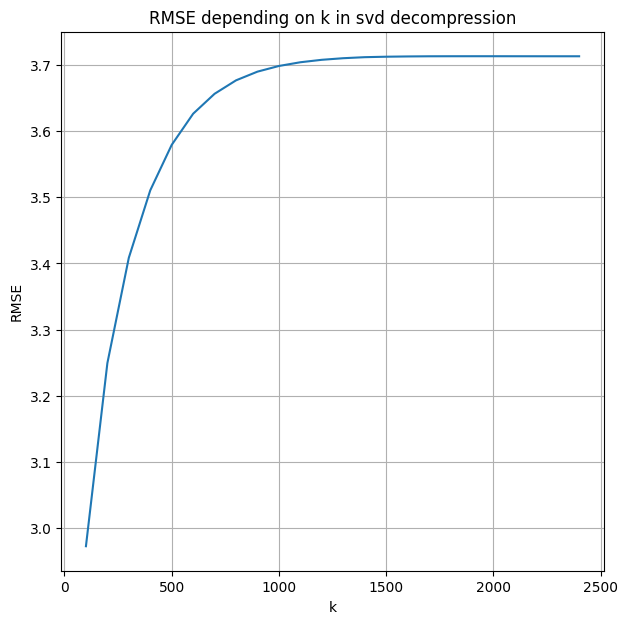

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.plot(top_k_list, rmse_scores)
ax.set_title('RMSE depending on k in svd decompression')
ax.grid(True)
ax.set_xlabel('k')
ax.set_ylabel('RMSE')

plt.show()

## Deep Learning

In [6]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm_notebook as tqdm

In [42]:
def genre_count(movies):
    # create map between genre and idx
    genre2idx = dict()
    idx2genre = dict()
    idx = 0
    # search for each genre in dataset
    for line in movies['genres']:
        genres = list(map(lambda x: x.lower(), line.split('|')))
        for genre in genres:
            if genre2idx.get(genre, -1) == -1:
                genre2idx[genre] = idx
                idx2genre[idx] = genre
                idx += 1

    # save amount of genres
    genre_dim = idx
    
    # return result
    return genre2idx, idx2genre, genre_dim

class MovieLenDataset(Dataset):

    def __init__(self, dataset_rating, dataset_movie, mapping):
        super().__init__()
        
        # save our datasets
        self.rating = dataset_rating
        self.movie = dataset_movie
        
        self.genre2idx = mapping['genre2idx']
        self.idx2genre = mapping['idx2genre']
        self.genre_dim = mapping['genre_dim']

    def __len__(self):
        return self.rating.shape[0]
    
    def __getitem__(self, index):
        user_row = self.rating.iloc[index]
        
        genres = list(map(lambda x: x.lower(), self.movie.iloc[int(user_row['movieId'] - 1)]['genres'].split('|')))
        genre_vector = torch.zeros(self.genre_dim)
        for genre in genres:
            genre_vector[self.genre2idx[genre]] = 1
            
        return {
            'userId': torch.tensor(user_row['userId'] - 1, dtype=torch.int),
            'movieId': torch.tensor(user_row['movieId'] - 1, dtype=torch.int),
            'genre': genre_vector,
            'rating': torch.tensor(user_row['rating'], dtype=torch.float)
        }

In [47]:
class recsys_model(nn.Module):

    def __init__(self, max_user_amount, max_movie_amount, max_genre_amount, emb_dim=384, hid_dim=512):
        super().__init__()

        # emb layers for user and item
        self.user_ini_emb = nn.Embedding(max_user_amount, emb_dim)
        self.item_ini_emb = nn.Embedding(max_movie_amount, emb_dim)

        # hid layers for user and item
        self.user_fc = nn.Sequential(
            nn.Linear(emb_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim * 2),
            nn.ReLU(),
            nn.Linear(hid_dim * 2, hid_dim * 4),
            nn.ReLU(),
            nn.Linear(hid_dim * 4, hid_dim * 8),
            nn.ReLU(),
            nn.Linear(hid_dim * 8, hid_dim * 4),
            nn.ReLU(),
            nn.Linear(hid_dim * 4, hid_dim * 2),
            nn.ReLU(),
            nn.Linear(hid_dim * 2, hid_dim)
        )

        self.item_fc = nn.Sequential(
            nn.Linear(emb_dim + max_genre_amount, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim * 2),
            nn.ReLU(),
            nn.Linear(hid_dim * 2, hid_dim * 4),
            nn.ReLU(),
            nn.Linear(hid_dim * 4, hid_dim * 8),
            nn.ReLU(),
            nn.Linear(hid_dim * 8, hid_dim * 4),
            nn.ReLU(),
            nn.Linear(hid_dim * 4, hid_dim * 2),
            nn.ReLU(),
            nn.Linear(hid_dim * 2, hid_dim)
        )

    # forward pass
    def forward(self, users, movies, genres):
        users_emb, items_emb = self.user_ini_emb(users), self.item_ini_emb(movies)
        items_emb = torch.cat((items_emb, genres), dim=1)
        users_hid_emb, items_hid_emb = self.user_fc(users_emb), self.item_fc(items_emb)

        return users_hid_emb, items_hid_emb

# define loss
def recsys_loss(lambda1, lambda2, users_hid_emb, items_hid_emb, ratings):
    first_part = torch.mean((torch.sum(users_hid_emb * items_hid_emb, dim=1) - ratings) ** 2)
    second_part = lambda1 * torch.mean(torch.sum(users_hid_emb ** 2, dim=1))
    third_part = lambda2 * torch.mean(torch.sum(items_hid_emb ** 2, dim=1))
    
    return first_part + second_part + third_part

In [48]:
def get_loaders(ratings, movies, mapping, test_size=0.1, test_batch_size=128, train_batch_size=256):
    # split dataset on train and test
    from sklearn.model_selection import train_test_split
    train_ratings, test_ratings = train_test_split(ratings, test_size=test_size)

    # get torch dataset
    train_dataset = MovieLenDataset(train_ratings, movies, mapping)
    test_dataset = MovieLenDataset(test_ratings, movies, mapping)

    # get torch dataloaders
    train_loader = DataLoader(
        train_dataset,
        shuffle=True,
        batch_size=train_batch_size
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=test_batch_size,
        shuffle=False
    )

    return train_loader, test_loader

In [55]:
def train_model(model, train_loader, num_epochs, lr):
    # configure parameters and other stuff for learning
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999))
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)
    lambda1, lambda2 = 0.02, 0.02

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    model.train()

    loss_per_epoch = list()
    losses_per_epoch = dict()

    # set amount of epochs
    for epoch in range(num_epochs):
        
        loss_epoch = list()
        tepoch = tqdm(train_loader, unit='batch')
        # learn model through the torch dataloader
        for batch in train_loader:
            users = batch['userId'].to(device)
            movies = batch['movieId'].to(device)
            ratings = batch['rating'].to(device)
            genres = batch['genre'].to(device)

            # get models' outputs
            users_output, items_output = model(users, movies, genres)

            # calculate loss
            loss = recsys_loss(lambda1, lambda2, users_output, items_output, ratings)

            # optimizer step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update epoch information
            tepoch.update(1)
            tepoch.set_description(f'Epoch: {epoch + 1}')
            tepoch.set_postfix(recsys_loss=loss.item())

            # add loss information
            loss_epoch.append(loss.item())
            
        scheduler.step()
        
        losses_per_epoch[epoch + 1] = loss_epoch
        loss_per_epoch.append(np.mean(loss_epoch))
    
    return model, losses_per_epoch, loss_per_epoch

In [56]:
# get genres' information
genre2idx, idx2genre, genre_dim = genre_count(movies)

# create mapping
mapping = dict()
mapping['genre2idx'] = genre2idx
mapping['idx2genre'] = idx2genre
mapping['genre_dim'] = genre_dim

# create loaders
train_loader, test_loader = get_loaders(ratings, movies, mapping)

# create recsys model
recsys = recsys_model(max_user_id, max_movie_id, genre_dim)

# train and get information about lossses
model, losses_per_epoch, loss_per_epoch = train_model(recsys, lr=0.001, num_epochs=2, train_loader=train_loader)

/tmp/ipykernel_28/3839696280.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tepoch = tqdm(train_loader, unit='batch')


  0%|          | 0/15819 [00:00<?, ?batch/s]

  0%|          | 0/15819 [00:00<?, ?batch/s]

In [65]:
def evaluate_model(model, test_loader, show_preds=False):
    """
    evaluate recsys model
    show preds: if it's true, return dataframe with ground truth and what was predicted
    """
    from sklearn.metrics import mean_squared_error
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    model.eval()
    
    rmse_results = list()
    preds = dict()
    preds['pred_rating'] = list()
    preds['rating'] = list()
    preds['userId'] = list()
    preds['movieId'] = list()
    show_preds_once = show_preds
    
    tepoch = tqdm(test_loader, unit='batch')
    for batch in test_loader:
        users = batch['userId'].to(device)
        movies = batch['movieId'].to(device)
        ratings = batch['rating'].numpy()
        genres = batch['genre'].to(device)

        # get models' outputs
        users_output, items_output = model(users, movies, genres)

        # calculate rating
        pred_ratings = torch.sum(users_output * items_output, dim=1).cpu().detach().numpy()
        rmse_metric = mean_squared_error(pred_ratings, ratings, squared=False)
        rmse_results.append(rmse_metric)
        
        if show_preds_once:
            preds['pred_rating'].extend(pred_ratings)
            preds['rating'].extend(ratings)
            preds['userId'].extend(users.cpu().detach().numpy())
            preds['movieId'].extend(movies.cpu().detach().numpy())
            show_preds_once = False

        # update epoch information
        tepoch.update(1)
    
    if show_preds:
        return np.mean(rmse_results), pd.DataFrame(preds).head(10) 

    return np.mean(rmse_results)

In [66]:
rmse, pred_ratings = evaluate_model(recsys, test_loader, True)

/tmp/ipykernel_28/3232053436.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tepoch = tqdm(test_loader, unit='batch')


  0%|          | 0/3516 [00:00<?, ?batch/s]

In [67]:
rmse

0.8701614

In [68]:
pred_ratings

,pred_rating,rating,userId,movieId
0,3.960511,3.5,19738,1182
1,2.734457,3.0,27072,4637
2,3.667068,5.0,2033,1703
3,3.974161,4.0,34854,8340
4,3.293738,4.0,33830,338
5,3.215837,1.5,31453,7142
6,4.305701,5.0,34131,1213
7,3.972190,4.0,1834,521
8,2.854531,5.0,33633,2173
9,3.834674,4.0,3760,3113
